In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tester as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
CIFAR-10 Dataset: 171MB [00:53, 3.21MB/s]                               


All files found!



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 10:
Image - Min Value: 24 Max Value: 130
Image - Shape: (32, 32, 3)
Label - Label Id: 4 Name: deer


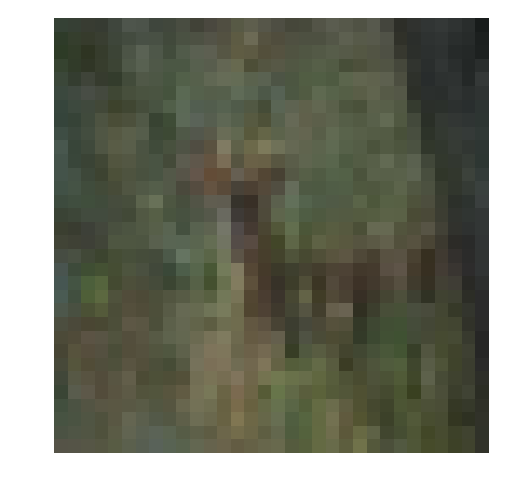

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 10
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data. The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return x / 255


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


In [4]:
from sklearn.preprocessing import LabelBinarizer

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # The possible values for labels are 0 to 9. 10 in total
    return np.eye(10)[x]


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [7]:
import pickle

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [9]:

import tensorflow  as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape=[None, *image_shape], name = "x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape=[None, n_classes], name = "y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name="keep_prob")


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


In [10]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # x_tensor.get_shape()
    # >> (?, 32, 32, 5)
    input_depth = x_tensor.shape[-1].value

    weights = tf.Variable(
        tf.truncated_normal(
            shape=[
                conv_ksize[0], # height
                conv_ksize[1], # width
                input_depth, # input_depth
                conv_num_outputs # out_depth
            ], 
            mean=0.0,
            stddev=0.1
        ),
        name='weights'
    )
    bias = tf.Variable(tf.zeros(conv_num_outputs), trainable=True)
    
    # Apply a convolution to x_tensor using weight and conv_strides
    conv_layer = tf.nn.conv2d(
        x_tensor, 
        weights, 
        strides=[1, *conv_strides, 1], 
        padding='SAME'
    )
    
    # Add bias
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    
    # Add a nonlinear activation to the convolution
    conv_layer = tf.nn.relu(conv_layer)
    
    # Apply Max Pooling using pool_ksize and pool_strides
    conv_layer = tf.nn.max_pool(
        conv_layer, 
        ksize=[1, *pool_ksize, 1], 
        strides=[1, *pool_strides, 1], 
        padding='SAME'
    )
    
    return conv_layer 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


In [11]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # print(x_tensor.get_shape()[1:4].num_elements())
    return tf.reshape(x_tensor, [-1, x_tensor.get_shape()[1:4].num_elements()])


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


In [13]:

def  fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    batch_size = x_tensor.shape[1].value
    weights = tf.Variable(
        tf.truncated_normal(
            [batch_size, num_outputs],
            mean = 0,
            stddev=0.1)
    )
    bias = tf.Variable(tf.zeros(num_outputs))

    fully_conn_layer = tf.matmul(x_tensor, weights)
    fully_conn_layer = tf.nn.bias_add(fully_conn_layer, bias)
    fully_conn_layer = tf.nn.relu(fully_conn_layer)

    return fully_conn_layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


In [15]:

def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    batch_size = x_tensor.shape[1].value
    weights = tf.Variable(
        tf.truncated_normal(
            [batch_size, num_outputs],
            mean = 0,
            stddev=0.1)
    )
    bias = tf.Variable(tf.zeros(num_outputs))
    
    output_layer = tf.matmul(x_tensor, weights)
    output_layer = tf.nn.bias_add(output_layer, bias)
    
    return output_layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


In [16]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    conv_num_outputs_layer1 = 32
    conv_num_outputs_layer2 = 64
    conv_num_outputs_layer3 = 128
    fully_conn_num_outputs_layer_1 = 256
    fully_conn_num_outputs_layer_2 = 512
    conv_ksize = (5, 5)
    conv_strides = (1, 1)
    pool_ksize = (2, 2)
    pool_strides = (2, 2)
    
    common_params = [conv_ksize, conv_strides, pool_ksize, pool_strides]
    
    # Apply 1, 2, or 3 Convolution and Max Pool layers
    conv_layer_1 = conv2d_maxpool(x, conv_num_outputs_layer1, *common_params)
    conv_layer_1 = tf.nn.dropout(conv_layer_1, keep_prob)
    
    conv_layer_2 = conv2d_maxpool(conv_layer_1, conv_num_outputs_layer2, *common_params)
    conv_layer_2 = tf.nn.dropout(conv_layer_2, keep_prob)
    
    conv_layer_3 = conv2d_maxpool(conv_layer_2, conv_num_outputs_layer3, *common_params)
    conv_layer_3 = tf.nn.dropout(conv_layer_3, keep_prob)
    
    # Apply a Flatten Layer
    flatten_layer_1 = flatten(conv_layer_3)

    # Apply 1, 2, or 3 Fully Connected Layers
    fully_conn_layer_1 = fully_conn(flatten_layer_1, fully_conn_num_outputs_layer_1)
    fully_conn_layer_1 = tf.nn.dropout(fully_conn_layer_1, keep_prob)
    fully_conn_layer_2 = fully_conn(flatten_layer_1, fully_conn_num_outputs_layer_2)
    fully_conn_layer_2 = tf.nn.dropout(fully_conn_layer_2, keep_prob)
    
    
    # Apply an Output Layer
    num_outputs = 10 # 10 classes
    output_layer = output(fully_conn_layer_2, num_outputs)
    
    return output_layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Neural Network Built!


In [17]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


In [18]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
    accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
    print("Loss: {} Accuracy: {}".format(loss, accuracy))